In [49]:

import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import os
import math
import random
import string
import cv2
import re

import pathlib

In [50]:
# Define the path to this directory
PATH = os.path.abspath("") + "/"
slicedimage_path = os.path.join(PATH, "letter_images")
print(PATH)

# Control whether to process the raw placards or the processed placards
PROCESS_RAW_PLACARDS = False

/home/sghyseli/gadalin/cnn_trainer/cnn_alpha/


### Process the Initial Plates as needed

In [51]:
def slicePlacards():
    placard_path = PATH + "placards/selected_plates"

    # Create sub-images directory if it doesn't exist
    if not os.path.exists(slicedimage_path):
        os.mkdir(slicedimage_path)

    # Get the list of files in placard_path
    placard_files = os.listdir(placard_path)

        # Loop through all directories and subdirectories in placard_path
    for dirpath, dirnames, filenames in os.walk(placard_path):
        # Loop through each file in the current directory
        for filename in filenames:
            # Construct the full path of the input file
            input_file = os.path.join(dirpath, filename)

            # Read the image
            image = cv2.imread(input_file)

            # Calculate the positions of the horizontal and vertical lines 
            # based on the size of the image taken from platefinding parameters
            height, width, _ = image.shape
            x1 = int(0.05 * width)
            x2 = int(0.95 * width)
            y1 = int(0.8 * height)
            y2 = int(0.97 * height)

            x1_left = x1
            x2_left = int(x1 + (x2 - x1) / 2.3)
            mid_left = int((x2_left+x1_left)/2)

            x1_right = int(x2 - (x2 - x1) / 2.3)
            x2_right = x2
            mid_right = int((x2_right+x1_right)/2)

            # Crop the four rectangles with character position indexed
            cropped_images = [image[y1:y2, x1_left:mid_left],
                                image[y1:y2, mid_left:x2_left],
                                image[y1:y2, x1_right:mid_right],
                                image[y1:y2, mid_right:x2_right]]

            # Extract the required letters from the filename
            parts = filename.split('_')
            # We take the second _ subset _ of the file name that contains the letters and digits
            letters = [parts[1][0], parts[1][1], parts[1][2], parts[1][3]]


            # Construct the new filenames and save the cropped images
            # The file names are {Character}{Position}_{OriginalFilename}
            for i in range(4):
                output_filename = f"{letters[i]}{i}_{filename}"
                output_dir = os.path.join(slicedimage_path, output_filename)
                cv2.imwrite(output_dir, cropped_images[i])

if (PROCESS_RAW_PLACARDS):
    slicePlacards()


### Image Preprocessing

In [52]:
#2 selected for now for testing

def preprocess_image(img):
    img = cv2.resize(img, (40, 40))
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Define the RGB values for the blue color of parked cars
    rgb_blue = (6, 6, 99)

    # Convert the RGB values to HSV color space
    hsv_blue = cv2.cvtColor(np.uint8([[rgb_blue]]), cv2.COLOR_RGB2HSV)[0][0]

    # Argument order is Hue, Saturation, Value
    # Define the lower and upper bounds for the blue color
    hsv_lower_blue = np.array([hsv_blue[0] - 1, 80, 50])
    hsv_upper_blue = np.array([hsv_blue[0] + 1, 255, 200])

    # Create a mask for the blue color
    mask = cv2.inRange(hsv, hsv_lower_blue, hsv_upper_blue)

    # Apply the mask to the blue channel of the original image
    blue_channel = img[:, :, 2]
    blue_parts = cv2.bitwise_and(blue_channel, blue_channel, mask=mask)

    # Convert the resulting image to greyscale
    grey_blue_parts = cv2.cvtColor(cv2.merge((blue_parts, blue_parts, blue_parts)), cv2.COLOR_RGB2GRAY)

    return grey_blue_parts



### Prepare Training Set with Labeling and Histogram of Data

In [53]:

def get_char_label(file_name):
    """
    Extracts the letter from the filename.

    The label is assumed to be the first character of the filename

    Args:
        file_name (str): The name of the image file.

    Returns:
        int: The char_label of the image.

    Raises:
        None
    """
    # Extract the first character of the filename
    label_char = file_name[0]
    # Return the label
    return label_char

def get_pos_label(file_name):
    """
    Extracts the label from the filename.

    The label is assumed to be the second character of the filename, which is always an integer.

    Args:
        file_name (str): The name of the image file.

    Returns:
        int: The pos_label of the image.

    Raises:
        None
    """
    # Extract the second character of the filename
    label_pos = file_name[1]
    # Return the label
    return label_pos

# Get the list of files in slicedimage_path
sliced_files = os.listdir(slicedimage_path)

# Initialize empty arrays for parking number images and labels
char_set = []
char_labels = []
pos_labels = []

# Loop through each file in slicedimage_path, extract the character, position, image dataypes
for file_name in sliced_files:
    # Load the image and convert to RGB format
    image = cv2.imread(os.path.join(slicedimage_path, file_name))[:,:,::-1]
    image = preprocess_image(image)
    # Add the image and label to the arrays
    char_set.append(image)
    char_label = get_char_label(file_name)
    char_labels.append(char_label)
    pos_label = get_pos_label(file_name)
    pos_labels.append(pos_label)

# Convert the arrays to numpy arrays
char_set = np.array(char_set)
char_labels = np.array(char_labels)
pos_labels = np.array(pos_labels)

# Print the number of elements added to parking_number_set and the number of images in the set
print("Loaded {:} images from folder:\n{}".format(char_set.shape[0], slicedimage_path))
print("Loaded {:} char_labels.".format(char_labels.shape[0]))
print("Loaded {:} pos_labels.".format(pos_labels.shape[0]))

# Pair the images and labels together for shuffling
raw_data_list = []
for i in range(len(char_set)):
    raw_data_list.append((char_set[i], char_labels[i], pos_labels[i]))



Loaded 30892 images from folder:
/home/sghyseli/gadalin/cnn_trainer/cnn_alpha/letter_images
Loaded 30892 char_labels.
Loaded 30892 pos_labels.


In [54]:
# Shuffle the dataset
np.random.shuffle(raw_data_list)

# Split the parking_number_list to X_dataset and Y_dataset
X_dataset_raw = np.array([data[0] for data in raw_data_list])
Y_dataset_raw = np.array([data[1] for data in raw_data_list])
P_dataset_raw = np.array([data[2] for data in raw_data_list])

# Print the shape of X_dataset and Y_dataset
print("X_dataset shape:", X_dataset_raw.shape)
print("Y_dataset shape:", Y_dataset_raw.shape)
print("P_dataset shape:", P_dataset_raw.shape)


X_dataset shape: (30892, 40, 40)
Y_dataset shape: (30892,)
P_dataset shape: (30892,)


### Image Preprocessing Experiment Lab


In [55]:


# def preprocess_image1(img):
#     # Resize the image to 20x20
#     img_resized = cv2.resize(img, (20, 20))
    
#     # Extract the blue channel
#     blue_channel = img_resized[:, :, 2]

#     # Convert the blue channel to greyscale
#     grey_blue_channel = cv2.cvtColor(cv2.merge((blue_channel, blue_channel, blue_channel)), cv2.COLOR_RGB2GRAY)
    
#     return grey_blue_channel


# def preprocess_image2(img):
#     img = cv2.resize(img, (20, 20))
#     # Convert the image to HSV color space
#     hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

#     # Define the RGB values for the blue color of parked cars
#     rgb_blue = (6, 6, 99)

#     # Convert the RGB values to HSV color space
#     hsv_blue = cv2.cvtColor(np.uint8([[rgb_blue]]), cv2.COLOR_RGB2HSV)[0][0]

#     # Argument order is Hue, Saturation, Value
#     # Define the lower and upper bounds for the blue color
#     hsv_lower_blue = np.array([hsv_blue[0] - 1, 80, 50])
#     hsv_upper_blue = np.array([hsv_blue[0] + 1, 255, 200])

#     # Create a mask for the blue color
#     mask = cv2.inRange(hsv, hsv_lower_blue, hsv_upper_blue)

#     # Apply the mask to the blue channel of the original image
#     blue_channel = img[:, :, 2]
#     blue_parts = cv2.bitwise_and(blue_channel, blue_channel, mask=mask)

#     # Convert the resulting image to greyscale
#     grey_blue_parts = cv2.cvtColor(cv2.merge((blue_parts, blue_parts, blue_parts)), cv2.COLOR_RGB2GRAY)

#     return grey_blue_parts

# def preprocess_image3(img):
#     # Convert the image to HSV color space
#     hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

#     # Define the RGB values for the blue color of parked cars
#     rgb_blue = (6, 6, 99)

#     # Convert the RGB values to HSV color space
#     hsv_blue = cv2.cvtColor(np.uint8([[rgb_blue]]), cv2.COLOR_RGB2HSV)[0][0]

#     # Argument order is Hue, Saturation, Value
#     # Define the lower and upper bounds for the blue color
#     hsv_lower_blue = np.array([hsv_blue[0] - 1, 50, 50])
#     hsv_upper_blue = np.array([hsv_blue[0] + 1, 255, 200])

#     # Create a mask for the blue color
#     mask = cv2.inRange(hsv, hsv_lower_blue, hsv_upper_blue)


#     # Convert the image to greyscale
#     grey_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#     # Apply the mask to the greyscale image
#     blue_parts = cv2.bitwise_and(grey_image, grey_image, mask=mask)

#     return blue_parts

# def preprocess_image4(img):
#     # Convert the image to HSV color space
#     hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

#     # Define the RGB values for the blue color of parked cars
#     rgb_blue = (6, 6, 99)

#     # Convert the RGB values to HSV color space
#     hsv_blue = cv2.cvtColor(np.uint8([[rgb_blue]]), cv2.COLOR_RGB2HSV)[0][0]

#     # Argument order is Hue, Saturation, Value
#     # Define the lower and upper bounds for the blue color
#     hsv_lower_blue = np.array([hsv_blue[0] - 1, 50, 50])
#     hsv_upper_blue = np.array([hsv_blue[0] + 1, 255, 200])

#     # Create a mask for the blue color
#     mask = cv2.inRange(hsv, hsv_lower_blue, hsv_upper_blue)

#     # Apply the mask to the original image
#     blue_parts = cv2.bitwise_and(img, img, mask=mask)

#     return blue_parts


# def preprocess_image5(img):
    
#     # Extract the blue channel
#     blue_channel = img[:, :, 2]

#     # Convert the blue channel to greyscale
#     grey_blue_channel = cv2.cvtColor(cv2.merge((blue_channel, blue_channel, blue_channel)), cv2.COLOR_RGB2GRAY)
    
#     return grey_blue_channel


In [56]:
# import matplotlib.pyplot as plt

# import ipywidgets as ipywidgets
# from ipywidgets import interact

# # Apply the preprocessing functions to the dataset
# X_dataset_preprocessed1 = [preprocess_image1(img) for img in X_dataset_raw]
# X_dataset_preprocessed2 = [preprocess_image2(img) for img in X_dataset_raw]
# X_dataset_preprocessed3 = [preprocess_image5(img) for img in X_dataset_raw]

# # Display images in the training data set. 
# def displayImage(index):
#     fig, axes = plt.subplots(1, 4, figsize=(20, 5))

#     axes[0].imshow(X_dataset_raw[index])
#     axes[0].set_title("Original")

#     axes[1].imshow(X_dataset_preprocessed1[index])
#     axes[1].set_title("Preprocessed 1")

#     axes[2].imshow(X_dataset_preprocessed2[index])
#     axes[2].set_title("Preprocessed 2")

#     axes[3].imshow(X_dataset_preprocessed3[index])
#     axes[3].set_title("Preprocessed 3")

#     plt.show()

# interact(displayImage, 
#          index=ipywidgets.IntSlider(min=0, max=20,
#                                     step=1, value=10))

### Labeling

In [57]:
NUMBER_OF_LABELS = 36
CONFIDENCE_THRESHOLD = 0.01

# Define the labels
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
positions = '0123'

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

Y_indices = np.array([labels.index(data[1]) for data in raw_data_list])
P_indices = np.array([positions.index(data[2]) for data in raw_data_list])

Y_dataset = convert_to_one_hot(Y_indices, NUMBER_OF_LABELS).T
P_dataset = convert_to_one_hot(P_indices, 4).T
# Normalize X (images) dataset
X_dataset = X_dataset_raw/255



In [ ]:

# Print the first 10 elements of Y_indices and Y_dataset
print("Y_indices[:10]:", Y_indices[:10])
print("Y_dataset[:10]:\n", Y_dataset[:10])
print("P_indices[:10]:", P_indices[:10])
print("P_dataset[:10]:\n", P_dataset[:10])
# Print the shape of X_dataset and Y_dataset
print("X_dataset shape:", X_dataset.shape)
print("Y_dataset shape:", Y_dataset.shape)
print("P_dataset shape:", P_dataset.shape)

print(type(P_dataset))

In [59]:
from ipywidgets import interact
import ipywidgets as ipywidgets

# Display images in the training data set. 
def displayImage(index):
  plt.imshow(X_dataset[index])
  caption = ("y = " + "Character " + str(labels[Y_indices[index]]) + \
             "\n" + "Pos: " + str(positions[P_indices[index]]) + \
             "\n" +  "  " +  str(Y_dataset[index]))
  
  plt.text(0.5, 0.5, caption, 
          color='black', fontsize = 10,
          horizontalalignment='left', verticalalignment='top')


interact(displayImage, 
         index=ipywidgets.IntSlider(min=0, max=20,
                                    step=1, value=1))
#displayImage(2)

interactive(children=(IntSlider(value=1, description='index', max=20), Output()), _dom_classes=('widget-intera…

<function __main__.displayImage(index)>

In [60]:
# Reshape the dataset so that it has a single channel for Greyscale and we can use it for 2D Conv
X_dataset = np.reshape(X_dataset, (-1, 40, 40, 1))

print(X_dataset.shape)

(30892, 40, 40, 1)


### Validate the Data and Distribution

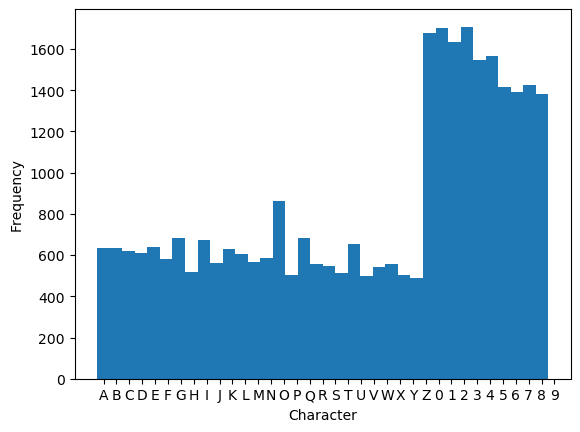

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Y_indices is an integer array containing the index of the character in the labels list
Y = Y_indices
X = X_dataset
P = P_indices

# Create a histogram of Y_indices
plt.hist(Y_indices, bins=len(labels), align='left')
plt.xticks(np.arange(len(labels)), labels)
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.show()



## Balance the Set

In [62]:
# Define the maximum number of samples in each bin
max_bin_count = 820

# Get the indices of the samples to keep for each bin
keep_indices = []
for bin_idx in range(len(labels)):
    bin_indices = np.where(Y_indices == bin_idx)[0]
    if len(bin_indices) > max_bin_count:
        # Randomly choose indices to keep if there are too many
        keep_indices_bin = np.random.choice(bin_indices, max_bin_count, replace=False)
    else:
        # Keep all indices if there are fewer than the maximum
        keep_indices_bin = bin_indices
    keep_indices.append(keep_indices_bin)

# Concatenate the indices to keep and shuffle
keep_indices = np.concatenate(keep_indices)
np.random.shuffle(keep_indices)

# Use the index split on all 3 datasets
X_dataset_downsampled = X_dataset[keep_indices,:,:,]
Y_dataset_downsampled = Y_dataset[keep_indices,:]
Y_indices_downsampled = Y_indices[keep_indices]
P_dataset_downsampled = P_dataset[keep_indices,:]
P_indices_downsampled = P_indices[keep_indices]

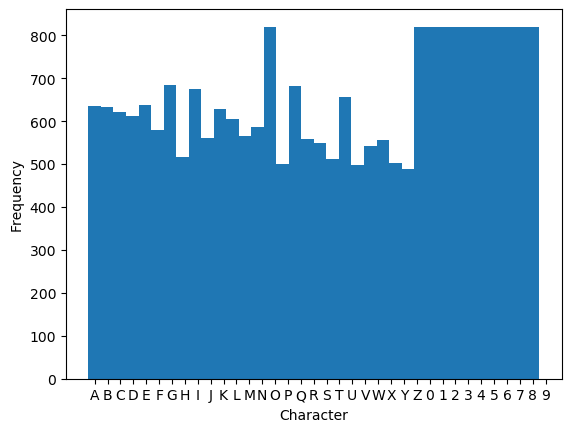

In [63]:


# Create a histogram of Y_indices
plt.hist(Y_indices_downsampled, bins=len(labels), align='left')
plt.xticks(np.arange(len(labels)), labels)
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.show()


### Set a Training and Validation Set

In [64]:
VALIDATION_SPLIT = 0.2

# Create a dictionary to store the indices of the samples for each character type:
char_indices = {}
for char in range(len(labels)):
    char_indices[char] = np.where(Y_indices_downsampled == char)[0]

# For each character type, randomly shuffle the corresponding indices and 
# split them into training and validation sets based on a given ratio 
# (e.g., 0.8 for 80% training and 20% validation):
train_indices = []
val_indices = []
for char in range(len(labels)):
    char_indices_shuffled = np.random.permutation(char_indices[char])
    split_index = int(len(char_indices_shuffled) * (1-VALIDATION_SPLIT))
    train_indices.extend(char_indices_shuffled[:split_index])
    val_indices.extend(char_indices_shuffled[split_index:])

# Use the index split on all 3 datasets
X_train_dataset = X_dataset_downsampled[train_indices,:,:]
Y_train_dataset = Y_dataset_downsampled[train_indices,:]
Y_train_indices = Y_indices_downsampled[train_indices]
P_train_dataset = P_dataset_downsampled[train_indices,:]
P_train_indices = P_indices_downsampled[train_indices]

X_val_dataset = X_dataset_downsampled[val_indices,:,:]
Y_val_dataset = Y_dataset_downsampled[val_indices,:]
Y_val_indices = Y_indices_downsampled[val_indices]
P_val_dataset = P_dataset_downsampled[val_indices,:]
P_val_indices = P_indices_downsampled[val_indices]



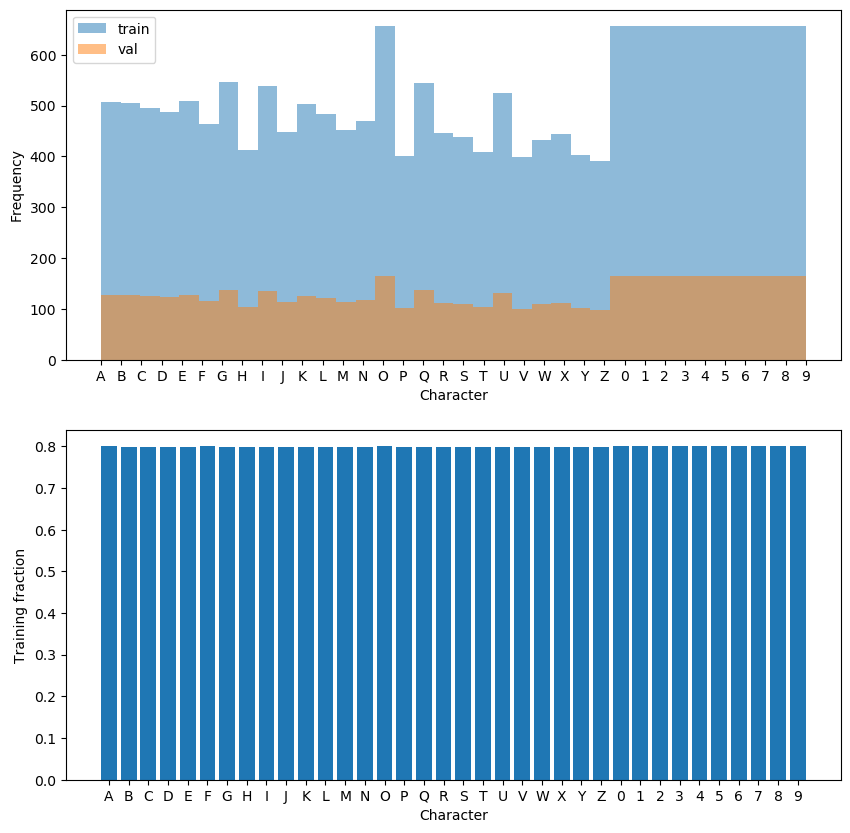

X shape: (30892, 40, 40, 1)
Y shape: (30892, 36)
Total examples: 30892
Training examples: 18871
Validation examples: 4733


In [65]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

train_hist, train_bins, _ = ax1.hist(Y_train_indices, bins=len(labels), alpha=0.5, label='train')
val_hist, val_bins, _ = ax1.hist(Y_val_indices, bins=len(labels), alpha=0.5, label='val')
ax1.set_xlabel('Character')
ax1.set_ylabel('Frequency')
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels)
ax1.legend()

ax2.bar(np.arange(len(labels)), train_hist/(train_hist+val_hist))
ax2.set_xlabel('Character')
ax2.set_ylabel('Training fraction')
ax2.set_xticks(np.arange(len(labels)))
ax2.set_xticklabels(labels)

plt.show()

print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))
print("Total examples: {:d}\nTraining examples: {:d}\n"
      "Validation examples: {:d}".
      format(X_dataset.shape[0],
             X_train_dataset.shape[0],
             X_val_dataset.shape[0]))

### Train the CNN on the Dataset

In [66]:
from keras import layers
from keras import models
from keras import optimizers
from keras.utils import plot_model
from keras import backend

In [67]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and 
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

### Define the CNN Model

In [68]:
# This is the sequential model
# # Model 2
# conv_model = models.Sequential()
# conv_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 1)))
# conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))

# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))

# conv_model.add(layers.Flatten())
# conv_model.add(layers.Dropout(0.5))
# conv_model.add(layers.Dense(256, activation='relu'))
# conv_model.add(layers.Dense(128, activation='relu'))
# conv_model.add(layers.Dense(26, activation='softmax'))

#### Data Augmentation

In [69]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation pipeline
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.05,
    preprocessing_function=lambda x: cv2.GaussianBlur(x, (2, 2), 0),
    fill_mode='nearest'
)

# Fit the data augmentation pipeline to the training data
datagen.fit(X_train_dataset)

In [70]:

MODEL_NAME = "modelC4rebuild"
# We convert a sequential model to a functional model to inject P_dataset into the model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout
from keras.models import Model

# Define CNN architecture
# Input has been shaped to (40, 40, 1) to match the shape of the image
# We hope to get our first subfeatures using two layers of covolution and max pooling
image_input = Input(shape=(40, 40, 1), name='image_input')
conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
conv2 = Conv2D(64, (3, 3), activation='relu')(conv1)
maxpool1 = MaxPooling2D((2, 2))(conv2)

# We build more complex features using two more layers of convolution and max pooling
conv3 = Conv2D(128, (3, 3), activation='relu')(maxpool1)
conv4 = Conv2D(256, (3, 3), activation='relu')(conv3)
maxpool2 = MaxPooling2D((2, 2))(conv4)

# Flatten the output of the last max pooling layer to send features into 1D vector for dense layers
flatten = Flatten()(maxpool2)
dropout1 = Dropout(0.5)(flatten)
dense1 = Dense(256, activation='relu')(dropout1)
dense2 = Dense(128, activation='relu')(dense1)

#Inject the postional data into the model directly before hitting the final classification layer
positional_input = Input(shape=P_dataset.shape[1], name='positional_input')  
combined_features = concatenate([dense2, positional_input])

# Add the final classification layer
num_classes = 36  # Set the number of classes for your character recognition task (A-Z and 0-9)
final_output = Dense(num_classes, activation='softmax', name='final_output')(combined_features)

# Create the new model with the two inputs and the final output
model = Model(inputs=[image_input, positional_input], outputs=[final_output])

In [ ]:
model.summary()

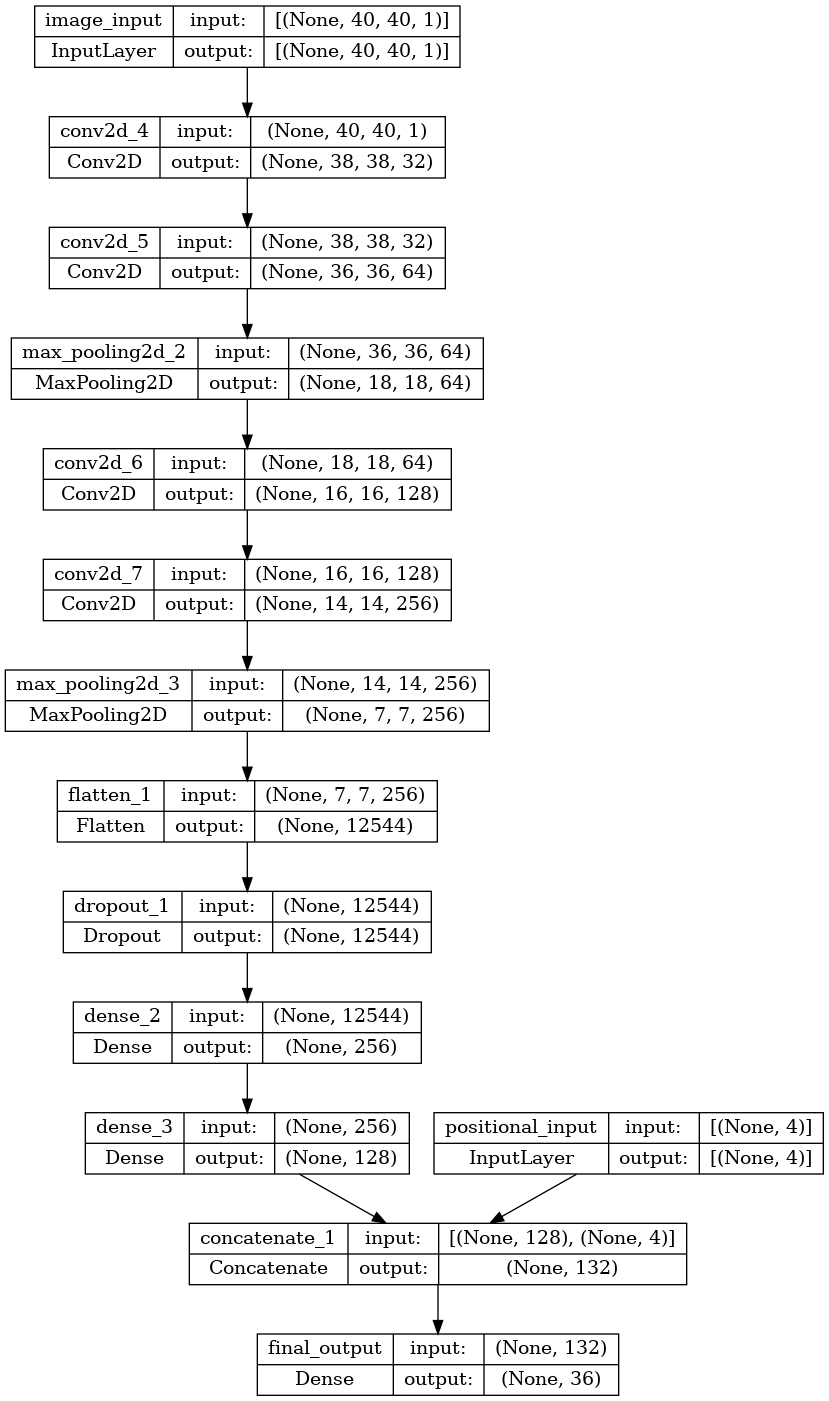

In [72]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file= MODEL_NAME + '.png', show_shapes=True, show_layer_names=True)

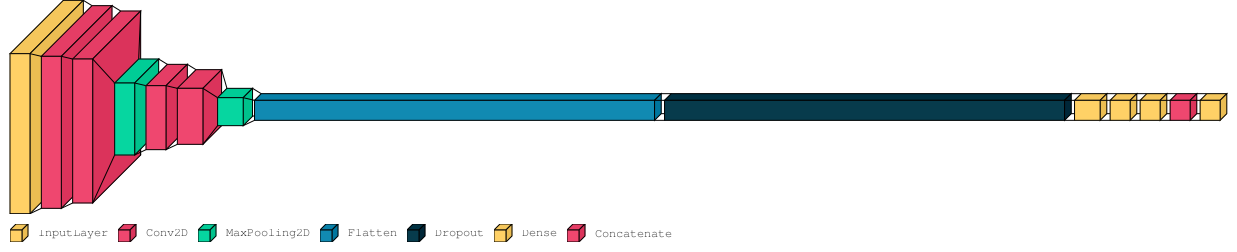

In [73]:
#https://www.analyticsvidhya.com/blog/2022/03/visualize-deep-learning-models-using-visualkeras/
# Visualization of the model
import visualkeras
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont
font = ImageFont.truetype("FreeMono.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font) # selected font

### Set Training

In [ ]:
# Boolean to set training on or off for run
train = 1

import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import ModelCheckpoint

# Create the weights folder if it doesn't exist
weights_dir = os.path.join(PATH, "weights")
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

# Define the configuration parameters
config = {
    "learning_rate": 1e-5,
    "optimizer": "RMSprop",
    "loss_function": "categorical_crossentropy",
    "metrics": ["accuracy"],
    "epochs": 40,
    "batch_size": 32,
}

# Create a ModelCheckpoint callback to save weights 
checkpoint = ModelCheckpoint(
    filepath=os.path.join(weights_dir, 'epoch_{epoch:02d}.h5'),  # Filepath pattern to save the weights
    save_weights_only=True,  # Set to True to save only weights, not the whole model
    save_freq='epoch',  # Save the weights after every epoch
    period=1,  # Save the weights every 10 epochs
    verbose=1  # Verbosity level, 1 means to print information about saved weights
)


model.compile(loss=config["loss_function"],
                   optimizer=optimizers.RMSprop(lr=config["learning_rate"]),
                   metrics=['acc'])



if(train == 1):
    reset_weights(model)
    # start a new wandb run to track this script
    wandb.init(project="Alpha_Chars", config=config)

    # Dual inputs into the mixed model
    history_conv = model.fit([X_train_dataset, P_train_dataset], Y_train_dataset, 
                             validation_data=([X_val_dataset, P_val_dataset], Y_val_dataset), 
                             epochs=config["epochs"], 
                             batch_size=config["batch_size"],
                             callbacks=[WandbCallback(), checkpoint])
                            #  callbacks=[ checkpoint])
    
    # [optional] finish the wandb run, necessary in notebooks
    wandb.finish()

    


### Display metrics

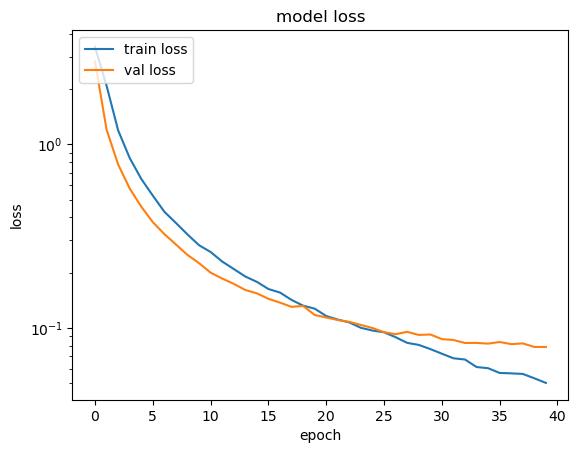

In [80]:
if(train == 1):
  # convert y-axis to Logarithmic scale
  plt.yscale("log")
  plt.plot(history_conv.history['loss'])
  plt.plot(history_conv.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'val loss'], loc='upper left')
  plt.show()

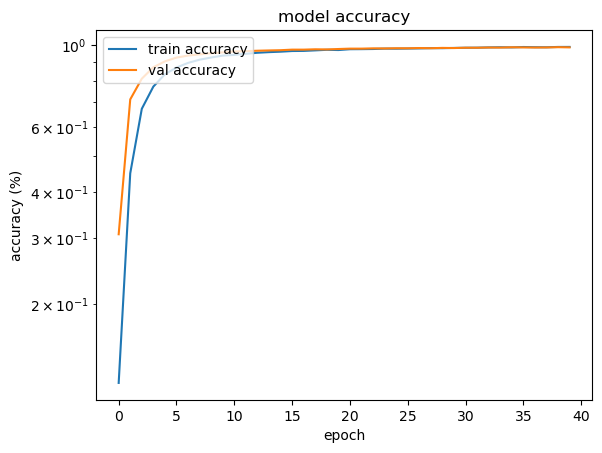

In [81]:
if(train == 1):
  # convert y-axis to Logarithmic scale
  plt.yscale("log")
  plt.plot(history_conv.history['acc'])
  plt.plot(history_conv.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy (%)')
  plt.xlabel('epoch')
  plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
  plt.show()

In [82]:
if (train == 1):
    # serialize model to JSON
    model_json = model.to_json()
    with open(os.path.join(PATH, f"{MODEL_NAME}.json"), "w") as json_file:  # Use MODEL_NAME here
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(os.path.join(PATH, f"{MODEL_NAME}.h5"))  # Use MODEL_NAME here
    print("Saved model to disk")

Saved model to disk


In [83]:
from keras.models import Sequential, model_from_json
# load json and create model

# load json and create model
with open(os.path.join(PATH, f"{MODEL_NAME}.json"), 'r') as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights(os.path.join(PATH, f"{MODEL_NAME}.h5"))
print("Loaded model from disk")

Loaded model from disk


### Test model loading correct

In [84]:
# Select a few samples from the validation dataset
num_samples = 5
sample_indices = np.random.choice(X_val_dataset.shape[0], num_samples, replace=False)

# Make predictions
X_samples = X_val_dataset[sample_indices]
P_samples = P_val_dataset[sample_indices]
predictions = loaded_model.predict([X_samples, P_samples])

# Get the predicted labels and the correct labels
predicted_labels = np.argmax(predictions, axis=1)
correct_labels = np.argmax(Y_val_dataset[sample_indices], axis=1)

# Print the results
for i in range(num_samples):
    print(f"Sample {i + 1}:")
    print(f"  Predicted label: {labels[predicted_labels[i]]}")
    print(f"  Correct label: {labels[correct_labels[i]]}")

1/1 [==============================] - 0s 66ms/step
Sample 1:
  Predicted label: P
  Correct label: P
Sample 2:
  Predicted label: S
  Correct label: S
Sample 3:
  Predicted label: H
  Correct label: H
Sample 4:
  Predicted label: Z
  Correct label: Z
Sample 5:
  Predicted label: L
  Correct label: L
